# Word-Level Handwritten OCR on the IAM Dataset

In this project, we implement a deep learning–based OCR system for handwritten word recognition.
The approach uses a ResNet18 backbone, a bidirectional LSTM, and CTC loss.
Experiments are conducted on the IAM Handwriting Database.

Students:

_Baris Surmelioglu - 152048_

_Ozan Polat - 150918_

In [2]:
import os
import warnings
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as T
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

words_new.txt: archive\words_new.txt
project_root: .
images_root: archive\iam_words\words
checked_ok_samples: 50
found: 50
missing: 0

first_5_samples:
a01-000u-00-00 | A | archive\iam_words\words\a01\a01-000u\a01-000u-00-00.png
a01-000u-00-01 | MOVE | archive\iam_words\words\a01\a01-000u\a01-000u-00-01.png
a01-000u-00-02 | to | archive\iam_words\words\a01\a01-000u\a01-000u-00-02.png
a01-000u-00-03 | stop | archive\iam_words\words\a01\a01-000u\a01-000u-00-03.png
a01-000u-00-04 | Mr. | archive\iam_words\words\a01\a01-000u\a01-000u-00-04.png


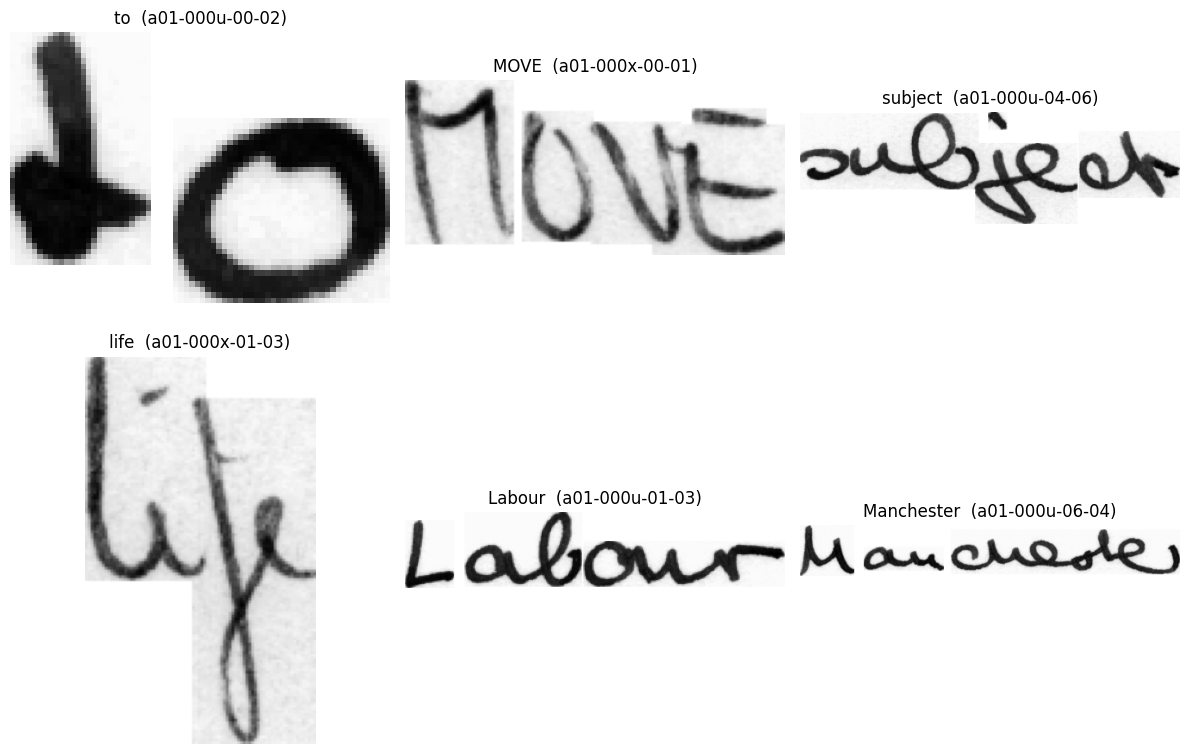

In [4]:
words_file = Path("archive") / "words_new.txt"
if not words_file.exists():
    here = Path.cwd().resolve()
    found = None
    for p in [here] + list(here.parents):
        candidate = p / "archive" / "words_new.txt"
        if candidate.exists():
            found = candidate
            break
    if found is None:
        raise FileNotFoundError("words_new.txt not found. Make sure the notebook is inside CV-Project3 or provide the full path.")
    words_file = found

project_root = words_file.parent.parent
images_root = project_root / "archive" / "iam_words" / "words"

def parse_ok_samples(path: Path, limit: int = 50):
    samples = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            word_id = parts[0]
            status = parts[1]
            if status != "ok":
                continue
            label = parts[-1]
            a01 = word_id.split("-")[0]
            a01_000u = "-".join(word_id.split("-")[:2])
            img_path = images_root / a01 / a01_000u / f"{word_id}.png"
            samples.append((word_id, str(label), img_path))
            if len(samples) >= limit:
                break
    return samples

samples = parse_ok_samples(words_file, limit=50)
exists_flags = [p.exists() for _, _, p in samples]
missing = [s for s, ok in zip(samples, exists_flags) if not ok]

print("words_new.txt:", str(words_file))
print("project_root:", str(project_root))
print("images_root:", str(images_root))
print("checked_ok_samples:", len(samples))
print("found:", sum(exists_flags))
print("missing:", len(missing))

print("\nfirst_5_samples:")
for word_id, label, img_path in samples[:5]:
    print(word_id, "|", label, "|", img_path)

if missing:
    print("\nfirst_10_missing:")
    for word_id, label, img_path in missing[:10]:
        print(word_id, "|", label, "|", img_path)

try:
    from PIL import Image
    import matplotlib.pyplot as plt

    valid = [s for s in samples if s[2].exists()]
    k = min(6, len(valid))
    pick = random.sample(valid, k) if k > 0 else []
    if pick:
        cols = 3
        rows = (k + cols - 1) // cols
        plt.figure(figsize=(12, 4 * rows))
        for i, (word_id, label, img_path) in enumerate(pick, 1):
            img = Image.open(img_path).convert("L")
            plt.subplot(rows, cols, i)
            plt.imshow(img, cmap="gray")
            plt.title(f"{label}  ({word_id})")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("\npreview_skipped:", str(e))

total_ok_with_existing_images: 38305


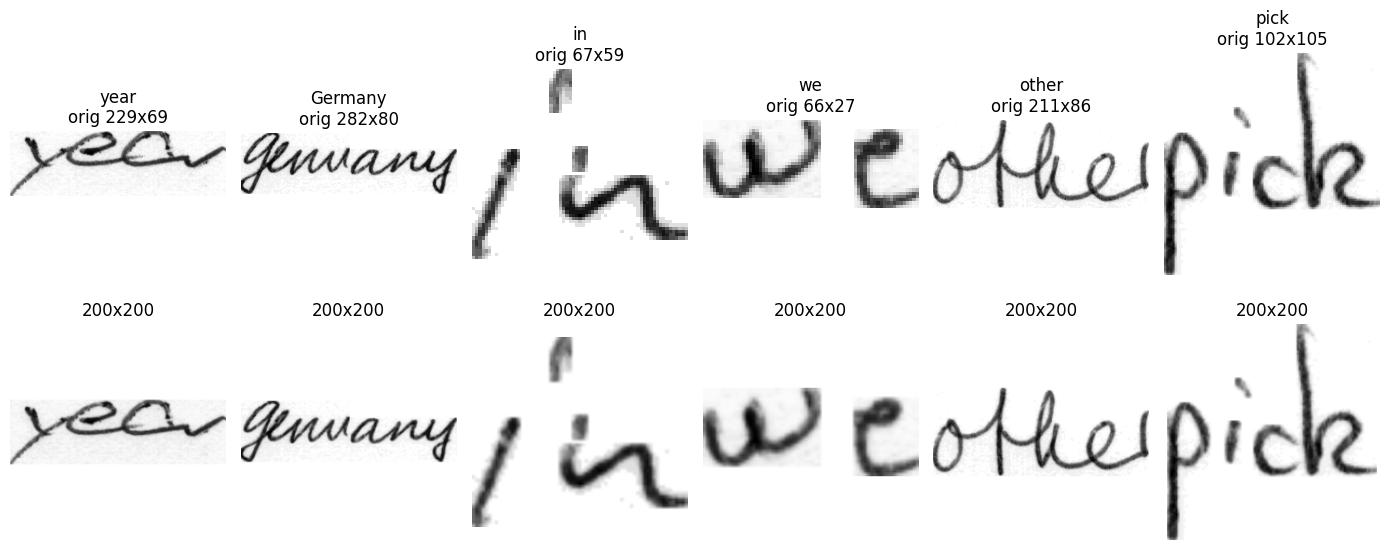

preprocessed_shape: (200, 200) min: 0.07450980693101883 max: 1.0


In [5]:
words_file = Path("archive") / "words_new.txt"
if not words_file.exists():
    here = Path.cwd().resolve()
    found = None
    for p in [here] + list(here.parents):
        candidate = p / "archive" / "words_new.txt"
        if candidate.exists():
            found = candidate
            break
    if found is None:
        raise FileNotFoundError("words_new.txt not found.")
    words_file = found

project_root = words_file.parent.parent
images_root = project_root / "archive" / "iam_words" / "words"

def iter_ok_samples(path: Path):
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            word_id = parts[0]
            status = parts[1]
            if status != "ok":
                continue
            label = parts[-1]
            grp = word_id.split("-")[0]
            sub = "-".join(word_id.split("-")[:2])
            img_path = images_root / grp / sub / f"{word_id}.png"
            if img_path.exists():
                yield word_id, label, img_path

def preprocess_200x200(img: Image.Image, target_size=200, pad_value=255):
    img = img.convert("L")
    w, h = img.size
    if w == 0 or h == 0:
        raise ValueError("Invalid image size.")
    scale = target_size / max(w, h)
    nw = max(1, int(round(w * scale)))
    nh = max(1, int(round(h * scale)))
    img_resized = img.resize((nw, nh), resample=Image.BILINEAR)
    canvas = Image.new("L", (target_size, target_size), color=pad_value)
    x0 = (target_size - nw) // 2
    y0 = (target_size - nh) // 2
    canvas.paste(img_resized, (x0, y0))
    arr = np.asarray(canvas, dtype=np.float32) / 255.0
    return arr

samples = list(iter_ok_samples(words_file))
print("total_ok_with_existing_images:", len(samples))

k = 6
pick = random.sample(samples, k)
plt.figure(figsize=(14, 6))
for i, (word_id, label, img_path) in enumerate(pick, 1):
    img = Image.open(img_path)
    pre = preprocess_200x200(img, target_size=200, pad_value=255)
    plt.subplot(2, k, i)
    plt.imshow(img.convert("L"), cmap="gray")
    plt.title(f"{label}\norig {img.size[0]}x{img.size[1]}")
    plt.axis("off")
    plt.subplot(2, k, i + k)
    plt.imshow(pre, cmap="gray")
    plt.title("200x200")
    plt.axis("off")
plt.tight_layout()
plt.show()

arr0 = preprocess_200x200(Image.open(pick[0][2]), target_size=200, pad_value=255)
print("preprocessed_shape:", arr0.shape, "min:", float(arr0.min()), "max:", float(arr0.max()))

In [6]:
words_file = Path("archive") / "words_new.txt"
project_root = words_file.parent.parent
images_root = project_root / "archive" / "iam_words" / "words"

allowed_prefixes = {"a", "b", "c", "d", "e"}

def load_samples_limited(path: Path):
    out = []
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            word_id = parts[0]
            status = parts[1]
            if status != "ok":
                continue
            grp = word_id.split("-")[0]
            if grp[:1] not in allowed_prefixes:
                continue
            label = parts[-1]
            sub = "-".join(word_id.split("-")[:2])
            img_path = images_root / grp / sub / f"{word_id}.png"
            if img_path.exists():
                out.append((str(img_path), label))
    return out

samples = load_samples_limited(words_file)
n = len(samples)
print("total_ok_with_existing_images_A_to_E:", n)

random.seed(42)
random.shuffle(samples)

n_train = int(0.8 * n)
n_val = int(0.1 * n)
train = samples[:n_train]
val = samples[n_train:n_train + n_val]
test = samples[n_train + n_val:]

splits_dir = project_root / "splits"
splits_dir.mkdir(parents=True, exist_ok=True)

def write_csv(rows, out_path: Path):
    with out_path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["path", "label"])
        w.writerows(rows)

write_csv(train, splits_dir / "train.csv")
write_csv(val, splits_dir / "val.csv")
write_csv(test, splits_dir / "test.csv")

print("train:", len(train), "val:", len(val), "test:", len(test))
print("wrote:", str(splits_dir / "train.csv"))
print("wrote:", str(splits_dir / "val.csv"))
print("wrote:", str(splits_dir / "test.csv"))

total_ok_with_existing_images_A_to_E: 38305
train: 30644 val: 3830 test: 3831
wrote: splits\train.csv
wrote: splits\val.csv
wrote: splits\test.csv


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,-'\"():;!? "
char2idx = {c: i + 1 for i, c in enumerate(alphabet)}
idx2char = {i + 1: c for i, c in enumerate(alphabet)}
blank_idx = 0
num_classes = len(alphabet) + 1

def encode_label(text):
    encoded = []
    for c in text:
        if c in char2idx:
            encoded.append(char2idx[c])
        elif c.lower() in char2idx:
            encoded.append(char2idx[c.lower()])
    if len(encoded) == 0:
        return None
    return torch.tensor(encoded, dtype=torch.long)

def levenshtein(a, b):
    n, m = len(a), len(b)
    if n == 0:
        return m
    if m == 0:
        return n
    prev = list(range(m + 1))
    for i in range(1, n + 1):
        cur = [i] + [0] * m
        ai = a[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ai == b[j - 1] else 1
            cur[j] = min(prev[j] + 1, cur[j - 1] + 1, prev[j - 1] + cost)
        prev = cur
    return prev[m]

def cer(pred, gt):
    pred_lower = pred.lower()
    gt_lower = gt.lower()
    d = levenshtein(list(pred_lower), list(gt_lower))
    return d / max(len(gt_lower), 1)

def wer(pred, gt):
    p = pred.lower().split()
    g = gt.lower().split()
    d = levenshtein(p, g)
    return d / max(len(g), 1)

def decode_greedy(log_probs):
    pred = log_probs.argmax(dim=2)
    results = []
    for seq in pred:
        prev = -1
        s = ""
        for p in seq:
            p = p.item()
            if p != prev and p != blank_idx:
                s += idx2char.get(p, "")
            prev = p
        results.append(s)
    return results

def preprocess_200x200_tensor(img, target_size=200, pad_value=255):
    img = img.convert("L")
    w, h = img.size
    if w == 0 or h == 0:
        return None
    
    scale = target_size / max(w, h)
    nw = max(1, int(round(w * scale)))
    nh = max(1, int(round(h * scale)))
    img_resized = img.resize((nw, nh), resample=Image.BILINEAR)
    
    canvas = Image.new("L", (target_size, target_size), color=pad_value)
    x0 = (target_size - nw) // 2
    y0 = (target_size - nh) // 2
    canvas.paste(img_resized, (x0, y0))
    
    arr = np.asarray(canvas, dtype=np.float32) / 255.0
    arr = (arr - 0.5) / 0.5
    return torch.from_numpy(arr).unsqueeze(0)

class IAMDataset(Dataset):
    def __init__(self, csv_file, augment=False):
        self.samples = []
        self.augment = augment
        with open(csv_file, newline="", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for r in reader:
                label = r["label"]
                if any(c in char2idx or c.lower() in char2idx for c in label):
                    self.samples.append((r["path"], label))
        
        self.aug_transforms = T.Compose([
            T.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        ]) if augment else None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path)
            if img is None:
                return None
            
            x = preprocess_200x200_tensor(img, target_size=200, pad_value=255)
            if x is None:
                return None
            
            if self.augment and self.aug_transforms is not None and random.random() < 0.5:
                x = self.aug_transforms(x)
            
            y = encode_label(label)
            if y is None or y.numel() == 0:
                return None
            
            return x, y, label
        except Exception:
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    imgs, labels, raw = zip(*batch)
    imgs = torch.stack(imgs)
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return imgs, labels, label_lens, raw

class OCRModel(nn.Module):
    def __init__(self, num_classes, rnn_hidden=256, rnn_layers=2, dropout=0.3):
        super().__init__()
        
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.conv1.weight.copy_(base.conv1.weight.mean(dim=1, keepdim=True))
        
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4

        self.seq_conv = nn.Conv2d(512, 512, kernel_size=(7, 1), stride=1, padding=(0, 0))
        self.expand_seq = nn.ConvTranspose2d(512, 256, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))

        
        self.rnn = nn.LSTM(
            input_size=256,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if rnn_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(rnn_hidden * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.seq_conv(x)
        x = self.expand_seq(x)
        
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        
        # RNN
        x, _ = self.rnn(x)
        x = self.dropout(x)
        
        # Output
        x = self.fc(x)
        
        return x.log_softmax(dim=2)

train_ds = IAMDataset("splits/train.csv", augment=True)
val_ds = IAMDataset("splits/val.csv", augment=False)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

train_loader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_ds, 
    batch_size=32, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

model = OCRModel(num_classes=num_classes, rnn_hidden=256, rnn_layers=2, dropout=0.3).to(device)
criterion = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, min_lr=1e-6)
writer = SummaryWriter()

epochs = 10
global_step = 0
best_cer = float('inf')

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0.0
    train_batches = 0
    
    for batch in train_loader:
        if batch is None:
            continue
        imgs, labels, label_lens, raw = batch
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        label_lens = label_lens.to(device)
        
        optimizer.zero_grad()
        
        out = model(imgs)
        
        T = out.size(1)
        batch_size = out.size(0)
        input_lens = torch.full((batch_size,), T, dtype=torch.long, device=device)
        
        out_ctc = out.permute(1, 0, 2)
        
        max_label_len = label_lens.max().item()
        if T < max_label_len:
            continue
        
        loss = criterion(out_ctc, labels, input_lens, label_lens)
        
        if torch.isnan(loss) or torch.isinf(loss):
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        train_batches += 1
        writer.add_scalar("train/loss", loss.item(), global_step)
        global_step += 1

    avg_train_loss = total_train_loss / max(train_batches, 1)

    # Validation
    model.eval()
    total_val_loss = 0.0
    val_batches = 0
    cer_list = []
    wer_list = []
    sample_preds = []
    
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            imgs, labels, label_lens, raw = batch
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            label_lens = label_lens.to(device)
            
            out = model(imgs)
            
            T = out.size(1)
            batch_size = out.size(0)
            input_lens = torch.full((batch_size,), T, dtype=torch.long, device=device)
            
            out_ctc = out.permute(1, 0, 2)
            
            vloss = criterion(out_ctc, labels, input_lens, label_lens)
            if not (torch.isnan(vloss) or torch.isinf(vloss)):
                total_val_loss += vloss.item()
                val_batches += 1
            
            preds = decode_greedy(out.cpu())
            for p, g in zip(preds, raw):
                cer_list.append(cer(p, g))
                wer_list.append(wer(p, g))
                if len(sample_preds) < 5:
                    sample_preds.append((g, p))

    avg_val_loss = total_val_loss / max(val_batches, 1)
    cer_m = sum(cer_list) / max(len(cer_list), 1)
    wer_m = sum(wer_list) / max(len(wer_list), 1)
    word_acc = sum(1 for c in cer_list if c == 0) / max(len(cer_list), 1)

    writer.add_scalar("epoch/train_loss", avg_train_loss, epoch)
    writer.add_scalar("epoch/val_loss", avg_val_loss, epoch)
    writer.add_scalar("val/cer", cer_m, epoch)
    writer.add_scalar("val/wer", wer_m, epoch)
    writer.add_scalar("val/word_accuracy", word_acc, epoch)
    writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch:02d} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | "
          f"CER: {cer_m:.4f} | WER: {wer_m:.4f} | Word_Acc: {word_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    print("  Samples:")
    for gt, pred in sample_preds[:3]:
        print(f"    GT: '{gt}' | Pred: '{pred}'")
    
    if cer_m < best_cer:
        best_cer = cer_m
        torch.save(model.state_dict(), "best_ocr_model.pth")
        print(f"  [Saved best model with CER: {best_cer:.4f}]")

writer.close()
print(f"\nTraining complete. Best CER: {best_cer:.4f}")

Train samples: 30616, Val samples: 3827
Epoch 00 | train_loss: 2.7823 | val_loss: 1.6633 | CER: 0.4850 | WER: 0.7403 | Word_Acc: 0.2597 | LR: 1.00e-04
  Samples:
    GT: 'the' | Pred: 'the'
    GT: 'range' | Pred: 'moe'
    GT: 'of' | Pred: 'of'
  [Saved best model with CER: 0.4850]
Epoch 01 | train_loss: 1.3340 | val_loss: 0.9998 | CER: 0.2638 | WER: 0.5628 | Word_Acc: 0.4372 | LR: 1.00e-04
  Samples:
    GT: 'the' | Pred: 'the'
    GT: 'range' | Pred: 'monge'
    GT: 'of' | Pred: 'of'
  [Saved best model with CER: 0.2638]
Epoch 02 | train_loss: 0.8746 | val_loss: 0.7211 | CER: 0.1895 | WER: 0.4722 | Word_Acc: 0.5278 | LR: 1.00e-04
  Samples:
    GT: 'the' | Pred: 'the'
    GT: 'range' | Pred: 'range'
    GT: 'of' | Pred: 'of'
  [Saved best model with CER: 0.1895]
Epoch 03 | train_loss: 0.6677 | val_loss: 0.6243 | CER: 0.1645 | WER: 0.4361 | Word_Acc: 0.5639 | LR: 1.00e-04
  Samples:
    GT: 'the' | Pred: 'the'
    GT: 'range' | Pred: 'rauge'
    GT: 'of' | Pred: 'of'
  [Saved best mo

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

model_size = os.path.getsize("best_ocr_model.pth") / (1024 * 1024)
print(f"Model size: {model_size:.2f} MB")

Total parameters: 16,198,411
Model size: 61.87 MB


In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)
print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

N_CORRECT = 20
N_WRONG = 30
N_WORST_BY_CER = 10

test_ds = IAMDataset("splits/test.csv", augment=False)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

state = torch.load("best_ocr_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state)
model.to(device)
model.eval()

test_cer = []
test_wer = []
total = 0
word_correct = 0

correct_samples = []
wrong_samples = []
worst_by_cer = []  # list of (cer_value, gt, pred)

with torch.no_grad():
    for batch in test_loader:
        if batch is None:
            continue

        imgs, labels, label_lens, raw = batch
        imgs = imgs.to(device)

        out = model(imgs)
        preds = decode_greedy(out.detach().cpu())

        for pred, gt in zip(preds, raw):
            total += 1

            c = cer(pred, gt)
            w = wer(pred, gt)
            test_cer.append(c)
            test_wer.append(w)

            is_correct = (gt.strip().lower() == pred.strip().lower())
            if is_correct:
                word_correct += 1
                if len(correct_samples) < N_CORRECT:
                    correct_samples.append((gt, pred))
            else:
                if len(wrong_samples) < N_WRONG:
                    wrong_samples.append((gt, pred))

            worst_by_cer.append((c, gt, pred))

final_cer = sum(test_cer) / max(len(test_cer), 1)
final_wer = sum(test_wer) / max(len(test_wer), 1)
word_acc = word_correct / max(total, 1)

# Also keep your original definition (CER==0) as "exact-word accuracy"
exact_word_acc = sum(1 for c in test_cer if c == 0) / max(len(test_cer), 1)

# Pick hardest mistakes by CER
worst_by_cer.sort(key=lambda x: x[0], reverse=True)
worst_by_cer = worst_by_cer[:N_WORST_BY_CER]

print(f"Test CER: {final_cer:.4f}")
print(f"Test WER: {final_wer:.4f}")
print(f"Test Word Accuracy (case-insensitive exact match): {word_acc:.4f}")
print(f"Test Exact Word Accuracy (CER==0): {exact_word_acc:.4f}")
print(f"Test Samples: {total}")

print("\n" + "-"*50)
print(f"Sample Predictions (Correct: {len(correct_samples)} shown)")
print("-"*50)
for gt, pred in correct_samples:
    print(f"  ✓ GT: '{gt}' | Pred: '{pred}'")

print("\n" + "-"*50)
print(f"Sample Predictions (Wrong: {len(wrong_samples)} shown)")
print("-"*50)
for gt, pred in wrong_samples:
    print(f"  ✗ GT: '{gt}' | Pred: '{pred}'")

print("\n" + "-"*50)
print(f"Hardest Mistakes by CER (Top {len(worst_by_cer)})")
print("-"*50)
for c, gt, pred in worst_by_cer:
    print(f"  CER={c:.3f} | GT: '{gt}' | Pred: '{pred}'")


TEST SET EVALUATION
Test CER: 0.1143
Test WER: 0.3467
Test Word Accuracy (case-insensitive exact match): 0.6533
Test Exact Word Accuracy (CER==0): 0.6533
Test Samples: 3825

--------------------------------------------------
Sample Predictions (Correct: 20 shown)
--------------------------------------------------
  ✓ GT: 'and' | Pred: 'and'
  ✓ GT: 'is' | Pred: 'is'
  ✓ GT: 'has' | Pred: 'has'
  ✓ GT: 'fit' | Pred: 'fit'
  ✓ GT: 'we' | Pred: 'we'
  ✓ GT: 'He' | Pred: 'He'
  ✓ GT: ',' | Pred: ','
  ✓ GT: 'today' | Pred: 'today'
  ✓ GT: 'would' | Pred: 'would'
  ✓ GT: '-' | Pred: '-'
  ✓ GT: 'has' | Pred: 'has'
  ✓ GT: 'some' | Pred: 'some'
  ✓ GT: 'to' | Pred: 'to'
  ✓ GT: 'good' | Pred: 'good'
  ✓ GT: 'the' | Pred: 'the'
  ✓ GT: 'their' | Pred: 'their'
  ✓ GT: 'other' | Pred: 'other'
  ✓ GT: '.' | Pred: '.'
  ✓ GT: 'the' | Pred: 'the'
  ✓ GT: 'in' | Pred: 'in'

--------------------------------------------------
Sample Predictions (Wrong: 30 shown)
-------------------------------------